In [12]:
!pip install mtcnn

In [17]:
import dlib
from mtcnn import MTCNN
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance
import scipy
import scipy.misc
from scipy import ndimage
import skimage.io
import skimage.filters
import sys

In [13]:
!mkdir /content/dataset
!mkdir /content/dataset/real
!mkdir /content/dataset/fake

mkdir: cannot create directory ‘/content/dataset’: File exists
mkdir: cannot create directory ‘/content/dataset/real’: File exists
mkdir: cannot create directory ‘/content/dataset/fake’: File exists


In [15]:
train_frame_folder = '/content/drive/MyDrive/train_sample_videos'
ct=0
with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = MTCNN()
for vid in list_of_train_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects=detector.detect_faces(frame)
            for i, d in enumerate(face_rects):
                x, y, width, height = face_rects[0]['box']
                x1,y1,x2,y2 = x-10,y+10,x-10 +width + 20,y+10+height
                crop_img = frame[y1:y2, x1:x2]
                if data[vid]['label'] == 'REAL':
                    cv2.imwrite('dataset/real/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                elif data[vid]['label'] == 'FAKE':
                    cv2.imwrite('dataset/fake/'+vid.split('.')[0]+'_'+str(count)+'.png',cv2.resize(crop_img, (128, 128)))
                count+=1

    ct+=1
    print(ct)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [18]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [17]:
input_shape = (128, 128, 3)
data_dir = '/content/dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [19]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

219070464/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 20
BATCH_SIZE = 100
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/20
33/33 [==============================] - 36s 465ms/step - loss: 0.6837 - accuracy: 0.5927 - val_loss: 0.8415 - val_accuracy: 0.5642
Epoch 2/20
33/33 [==============================] - 11s 342ms/step - loss: 0.5610 - accuracy: 0.7921 - val_loss: 0.7966 - val_accuracy: 0.5206
Epoch 3/20
33/33 [==============================] - 11s 343ms/step - loss: 0.4621 - accuracy: 0.8700 - val_loss: 0.7350 - val_accuracy: 0.5521
Epoch 4/20
33/33 [==============================] - 11s 342ms/step - loss: 0.3814 - accuracy: 0.9058 - val_loss: 0.6841 - val_accuracy: 0.6223
Epoch 5/20
33/33 [==============================] - 11s 342ms/step - loss: 0.3061 - accuracy: 0.9276 - val_loss: 0.6021 - val_accuracy: 0.7155
Epoch 6/20
33/33 [==============================] - 11s 342ms/step - loss: 0.2435 - accuracy: 0.9467 - val_loss: 0.5516 - val_accuracy: 0.7627
Epoch 7/20
33/33 [==============================] - 11s 343ms/step - loss: 0.1921 - accuracy: 0.9527 - val_loss: 0.4816 - val_accuracy: 0.8136

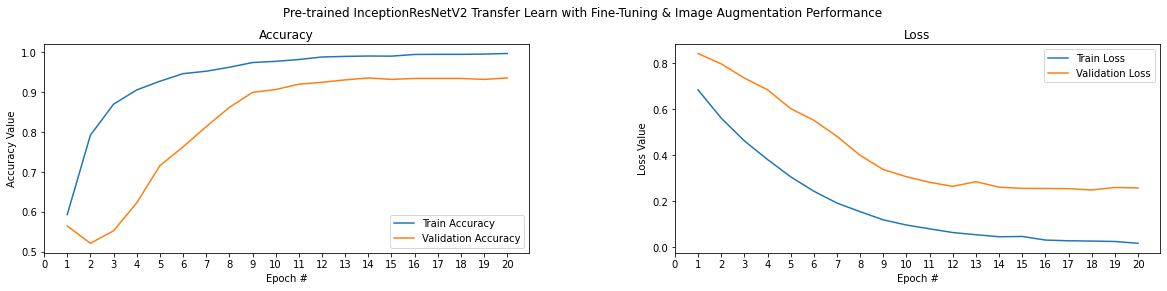

In [20]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionResNetV2 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [23]:
model.save('deepfake-detection-model.hdf5')

##TESTING

In [14]:
import tensorflow as tf
import mtcnn
import cv2
import os
import numpy as np
from mtcnn import MTCNN
from PIL import Image, ImageChops, ImageEnhance
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [15]:
model = load_model('/content/drive/MyDrive/deepfake-detection-model.hdf5')

In [21]:
input_shape = (128, 128, 3)
pr_data = []
detector = MTCNN()
#cap = cv2.VideoCapture('/content/drive/MyDrive/test_videos/aassnaulhq.mp4')
cap=cv2.VideoCapture('/content/drive/MyDrive/train_sample_videos/aagfhgtpmv.mp4')
frameRate = cap.get(5)
while cap.isOpened():
  frameId = cap.get(1)
  ret, frame = cap.read()
  if ret != True:
    break
  if frameId % ((int(frameRate)+1)*1) == 0:
    face_rects=detector.detect_faces(frame)
    for i, d in enumerate(face_rects):
      x, y, width, height = face_rects[0]['box']
      x1,y1,x2,y2 = x-10,y+10,x-10 +width + 20,y+10+height
      crop_img = frame[y1:y2, x1:x2]
      data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0
      data = data.reshape(-1, 128, 128, 3)
      print(model.predict(data))

[[0.6297813  0.37021872]]
[[0.6769913  0.32300872]]
[[0.27756765 0.7224323 ]]
[[0.71699625 0.28300372]]
[[0.6691242 0.3308758]]
[[0.5326348 0.4673652]]
[[0.0876537 0.9123463]]
[[0.67959785 0.32040215]]
[[0.55352384 0.4464762 ]]
[[0.38096157 0.6190384 ]]
[[0.38096157 0.6190384 ]]


##This is 2d vector output for each frame which indicates how real or fake that particular frame is. The 1st value indicates the closeness of the frame to being real and the 2nd one to a fake.